In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [18]:
data_folder = '/group/ag_compstatphys/data/tolga/simulation'

In [19]:
def sample_observables(file_name):

    file_path = f'{data_folder}/{file_name}'

    observables = {}
    num_regions = 0

    with h5py.File(file_path, 'r') as sim_data:

        stress_tensor = sim_data['observables/stress_tensor/value']
        stress_tensor = np.array(stress_tensor)
        observables['stress_tensor'] = np.mean(stress_tensor, axis = 0)    

        pressure = sim_data['observables/pressure/value']
        pressure = np.array(pressure)
        observables['pressure'] = np.mean(pressure)   

        return observables

In [20]:
def read_ssf(file_name):

    file_path = f'{data_folder}/{file_name}'
 

    with h5py.File(file_path, 'r') as sim_data:

        wavenumber = np.array(sim_data['structure/all/all/static_structure_factor/wavenumber'])
        
        # Calculate time averaged static structure along simulation box
        ssf = np.zeros((wavenumber.shape[0], 3))

        ssf = sim_data['structure/all/all/static_structure_factor/value']
        ssf_mean = np.average(np.array(ssf), axis = 0)

    return wavenumber, ssf_mean
    


## T = 1.0, rho = 0.7

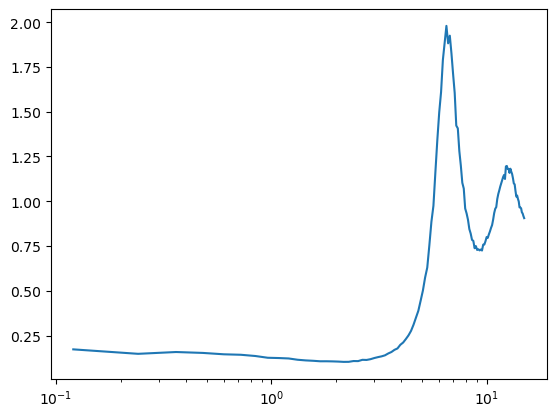

In [21]:
wavenumber, ssf = read_ssf("lj_production_T1_0_rho_0_7.h5")
plt.plot(wavenumber, ssf[:, 0])
plt.xscale("log")

In [22]:
def ornstein_zernike(params, q, rho, temp):
    """ Static structure factor in Ornstein-Zernike approximation """
    kappa, xi = params
    return rho * temp * kappa / (1 + (q * xi)**2)

In [23]:
import scipy.odr as odr


rho, temperature = 0.70, 1.0


kappa_liquid = np.mean(ssf[:, 1]) / rho / temperature # initial guess
# result is a tuple (param, param_err, covariance_matrix)
param, param_err = odr.odr(
    ornstein_zernike                        # fit model
    , (kappa_liquid, 1)                       # initial parameter values (kappa, xi)
    , ssf[:3, 1], ssf[:3, 0]  # data (y, x)
    , extra_args=(rho, temperature,), full_output=0
)[:2]


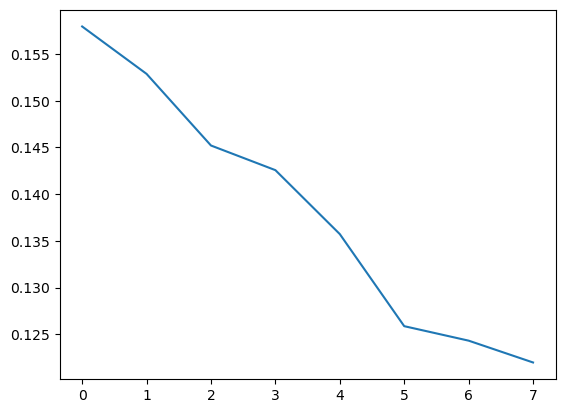

In [24]:
plt.plot(ssf[2:10,0])

In [25]:
from scipy.optimize import curve_fit

def lorentzian(q, s0, xi):

    return s0 / (1 + (q * xi)**2)

In [26]:
x = wavenumber[0:20]
y = ssf[0:20,0]

popt, pcov = curve_fit(lorentzian, x, y)
sigma_ab = np.sqrt(np.diagonal(pcov))


x_fit = np.linspace(0, 5, 100)
y_fit = lorentzian(x_fit, popt[0], popt[1])


0.12019301101241145

Fitted parameters: a=0.1616±0.0034, b=0.5106±0.0416


/tmp/ipykernel_482879/2845615514.py:35: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  jac[i] = derivative(f, params[i], n=1)


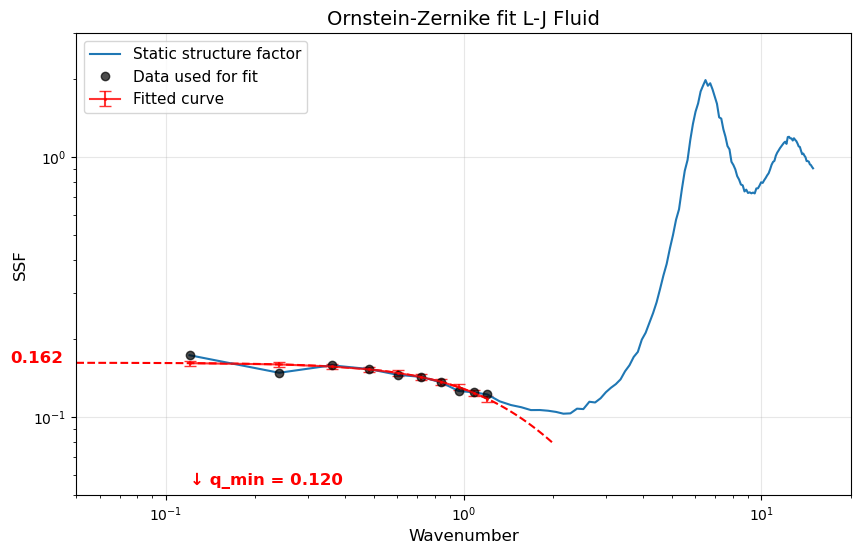

In [104]:

from scipy.misc import derivative

x_min = 0
x_max = 10

x = wavenumber[x_min:x_max]
y = ssf[x_min:x_max,0]



popt, pcov = curve_fit(lorentzian, x, y)


plot_range = np.linspace(0, 2, 100)
y_plot_range = lorentzian(plot_range, *popt)

perr = np.sqrt(np.diag(pcov))

print(f"Fitted parameters: a={popt[0]:.4f}±{perr[0]:.4f}, "
      f"b={popt[1]:.4f}±{perr[1]:.4f}")

# Create points for fitted curve (with error bars)
x_fit = np.linspace(x.min(), x.max(), x.shape[0])  
y_fit = lorentzian(x_fit, *popt)

# Calculate Jacobian (partial derivatives) numerically
def jacobian(x_vals, params):
    """Calculate Jacobian matrix: derivatives of model w.r.t. each parameter"""
    jac = np.zeros((len(params), len(x_vals)))
    for i, param in enumerate(params):
        def f(p):
            params_copy = params.copy()
            params_copy[i] = p
            return lorentzian(x_vals, *params_copy)
        jac[i] = derivative(f, params[i], n=1)
    return jac

jac = jacobian(x_fit, popt)

# Error propagation: σ_y = sqrt(sum((∂y/∂p_i * σ_p_i)^2))
y_err = np.sqrt(np.sum((jac * perr[:, np.newaxis])**2, axis=0))

# Plot
plt.figure(figsize=(10, 6))


# Original data
plt.errorbar(x, y, fmt='o', markersize=6, label='Data used for fit', 
             color='black', linestyle='none', capsize=5, alpha=0.7)

# Fitted curve with error bars
plt.errorbar(x_fit, y_fit, yerr=y_err, fmt='s', markersize=1, 
             label='Fitted curve', color='red', linestyle='-', 
             capsize=4, capthick=1, alpha=0.8)

plt.plot(plot_range, y_plot_range, color = 'red', ls = '--')


plt.plot(wavenumber, ssf[:,0], label = "Static structure factor")



plt.text(0.03, y_plot_range[0], f'{y_plot_range[0]:.3f}',
        fontsize=12, color='red', weight='bold')

plt.text(wavenumber[x_min], 0.055, f'↓ q_min = {wavenumber[x_min]:.3f}',
        fontsize=12, color='red', weight='bold')


plt.ylim(0.05, 3)
plt.xlim(0.05, 20)
plt.xlabel('Wavenumber', fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.ylabel('SSF', fontsize=12)
plt.title('Ornstein-Zernike fit L-J Fluid', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
#plt.tight_layout()
plt.show()

In [28]:
sigma_ab

array([0.00382989, 0.02402679])

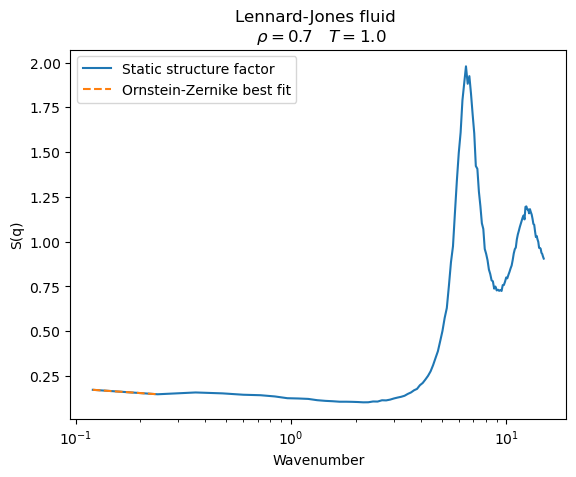

In [29]:
plt.plot(wavenumber, ssf[:,0], label = "Static structure factor")


plt.plot(x_fit, y_fit, ls = '--', label = "Ornstein-Zernike best fit")


plt.axvline(0, ls = '--', c = "g")


plt.xscale("log")


plt.title(r"Lennard-Jones fluid " "\n" r" $\rho = 0.7$   $T = 1.0$")
plt.xlabel("Wavenumber")
plt.ylabel("S(q)")

plt.legend()

plt.show()

In [30]:
lorentzian(0, popt[0], popt[1])

0.183029232195645

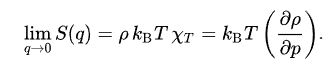

$ \chi_T = S(0) / (\rho k_B T) $

$k_B = 1$

0.161 / (1 * 1 * 0.7)

$ \chi_T = 0.23$

In [31]:
popt[0]

0.183029232195645

In [32]:
data_folder = '/group/ag_compstatphys/data/tolga/walls'
file_name = "crystalline_wall_200_ssf.h5"

file_path = f'{data_folder}/{file_name}'


with h5py.File(file_path, 'r') as sim_data:

    wavenumber = np.array(sim_data['ssf/global_parallel/wavenumber'])
    
    # Calculate time averaged static structure along simulation box
    ssf = np.zeros((wavenumber.shape[0], 3))

    ssf = sim_data['ssf/global_parallel/value']
    ssf_mean = np.average(np.array(ssf), axis = 0)



FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/group/ag_compstatphys/data/tolga/walls/crystalline_wall_200_ssf.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
ssf_mean.shape

(477, 3)

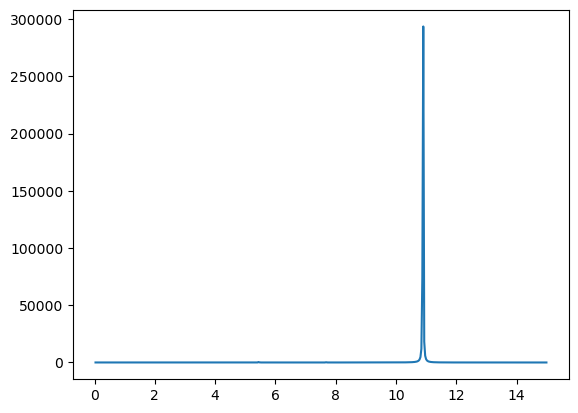

In [ ]:
plt.plot(wavenumber, ssf_mean[:,0])

## T = 1.3, rho = 0.7

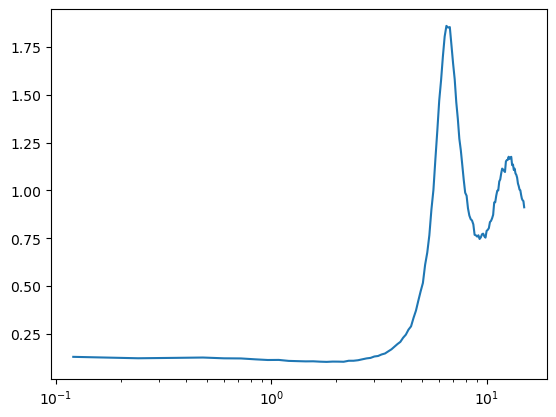

In [ ]:
wavenumber, ssf = read_ssf("lj_production_T1_3_rho_0_7.h5")
plt.plot(wavenumber, ssf[:, 0])
plt.xscale("log")

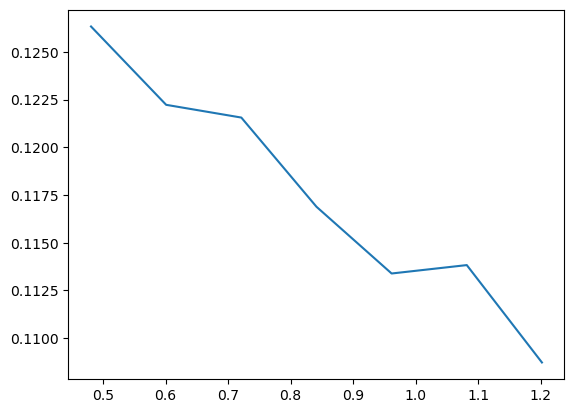

In [ ]:
plt.plot(wavenumber[3:10], ssf[3:10, 0])


In [ ]:
from scipy.optimize import curve_fit

def lorentzian(q, s0, xi):

    return s0 / (1 + (q * xi)**2)

In [ ]:
x = wavenumber[3:10]
y = ssf[3:10,0]

popt, pcov = curve_fit(lorentzian, x, y)

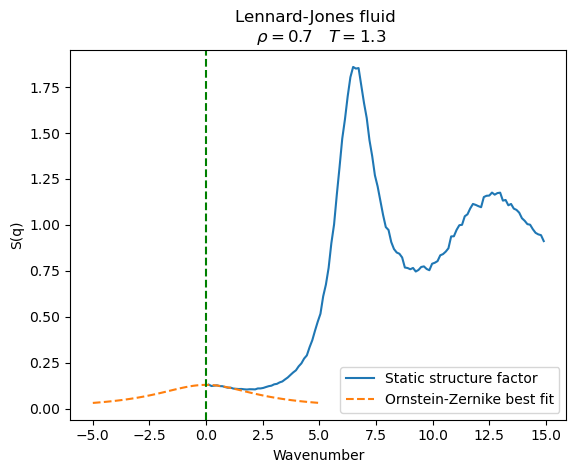

In [ ]:
plt.plot(wavenumber, ssf[:,0], label = "Static structure factor")

xx = np.linspace(-5, 5, 100)
plt.plot(xx, lorentzian(xx, popt[0], popt[1]), ls = '--', label = "Ornstein-Zernike best fit")


plt.axvline(0, ls = '--', c = "g")


#plt.xscale("log")


plt.title(r"Lennard-Jones fluid " "\n" r" $\rho = 0.7$   $T = 1.3$")
plt.xlabel("Wavenumber")
plt.ylabel("S(q)")

plt.legend()

plt.show()

In [ ]:
lorentzian(0, popt[0], popt[1])

0.12885434782257135

In [ ]:
0.12885434782257135 / (1.30 * 0.7)

0.14159818442040809

In [ ]:
0.14 

In [ ]:
0.23 